In [197]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import sys
import os
import cv2
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# Workflow

1. Dataset Creation
    * Generate patches from original sea lion images, each patch is 96 x 96 x 3. There are totally six patch classes: adult_males, subadult_males, adult_females, juveniles, pups and backgrounds. All the patch classes have the same numebr of samples.
    * Divide the patches into train, valid and test.

2. Build a normal CNN architecture for six-class classification. 
3. Convert CNN into FC-CNN.

## 1. Dataset Creation

In [198]:
IMAGE_PATH = '../data/images/'
PATCH_PATH = '../data/patches/'
CSV_PATH = '../data/coords.csv'

def inside(ul, ur, dl, dr, c):
    """ Check if two patches overlap
    """
    if ul[0] <= c[0] <= dl[0] and ul[1] <= c[1] <= ur[1]:
        return True
    else:
        return False

def gen_patches(n):
    """ Generate patches from original sea lion images
    Args:
        n: size of patches extracted for each class
    Return:
        data: python dictionary, key=class_name, value=list of image patch in numpy form
    """
    # delete previously generated patches if they exist
    files = glob.glob(PATCH_PATH + '*/*/*.png')
    for f in files:
        os.remove(f)
    
    data = {
        'adult_males': [],
        'subadult_males': [],
        'adult_females': [],
        'juveniles': [],
        'pups': [],
        'backgrounds': []
    }
    coords_df = pd.read_csv(CSV_PATH)
    
    # extract sea lion patches
    for tid in pd.unique(coords_df.tid):
        # check stopping criterion
        total = sum([len(data[key]) for key in data])
        if total == 5*n:
            break
        stat = coords_df[coords_df.tid == tid]
        img = cv2.imread(IMAGE_PATH + '{}.jpg'.format(tid))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for i in range(len(stat)):
            sealion_class = stat.iloc[i].class_name
            if len(data[sealion_class]) == n:
                continue
            row = stat.iloc[i].row
            col = stat.iloc[i].col
            patch = img[max(0, row - 48):min(img.shape[0], row + 48), max(0, col - 48):min(img.shape[1], col + 48), :]
            if patch.shape != (96, 96, 3):
                continue
            else:
                data[sealion_class].append(patch)
    print('sea lion patches extraction finished')
    
    # extract background patches
    for tid in pd.unique(coords_df.tid):
        stat = coords_df[coords_df.tid == tid]
        img = cv2.imread(IMAGE_PATH + '{}.jpg'.format(tid))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for r in range(img.shape[0] // 96):
            for c in range(img.shape[1] // 96):
                patch = img[96 * r:min(img.shape[0], 96 * (r + 1)), 96 * c:min(img.shape[1], 96 * (c + 1)), :]
                ul, ur = (r * 96, c * 96), (r * 96, (c + 1) * 96)
                dl, dr = ((r + 1) * 96, c * 96), ((r + 1) * 96, (c + 1) * 96)
                if patch.shape != (96, 96, 3):
                    continue
                not_overlapped = True
                for i in range(len(stat)):
                    row = stat.iloc[i].row
                    col = stat.iloc[i].col
                    if inside(ul, ur, dl, dr, (row, col)):
                        not_overlapped = False
                        break
                if not_overlapped:
                    data['backgrounds'].append(patch)
                    if len(data['backgrounds']) == n:
                        print('background patches extraction finished')
                        return data

In [201]:
n = 100
data = gen_patches(n)

sea lion patches extraction finished
background patches extraction finished


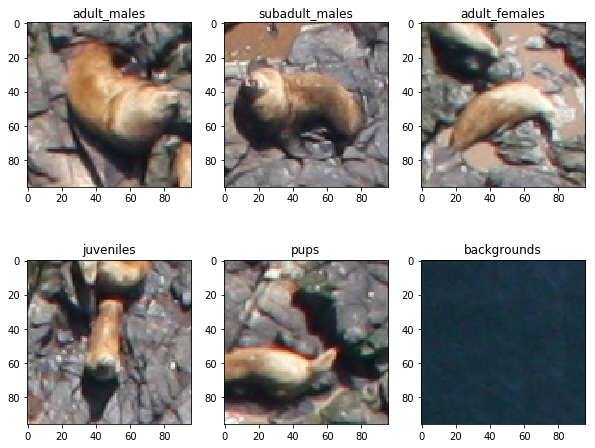

In [202]:
# show extraxted sea lion patch samples
plt.figure(figsize=(10, 8))
sealion_titles = ['adult_males', 'subadult_males', 'adult_females', 'juveniles', 'pups', 'backgrounds']
for i in range(1, 7):
    ax = plt.subplot(2, 3, i)
    ax.set_title(sealion_titles[i-1])
    ax.imshow(data[sealion_titles[i-1]][3])

In [203]:
# divide data into train, valid and test, then store them on the disc
n_train, n_valid, n_test = int(n*0.6), int(n*0.2), int(n*0.2)

# delete previously generated patches if they exist
files = glob.glob(PATCH_PATH + '*/*/*.png')
for f in files:
    os.remove(f)

for sealion_class in data.keys():
    for i in range(n):
        img = data[sealion_class][i]
        if i < n_train:
            path = PATCH_PATH + 'train/'
        elif i < n_train + n_valid:
            path = PATCH_PATH + 'valid/'
        else:
            path = PATCH_PATH + 'test/'
        cv2.imwrite(path + '{}/{}.png'.format(sealion_class, i),  cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## 2. Build CNN in Keras

CNN architecture
![cnn](./CNN.png)

In [204]:
model = Sequential()
# first layer
model.add(Convolution2D(8, (5, 5), activation='relu', padding='valid', input_shape=(96, 96, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
# second layer
model.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
# third layer
model.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
# fourth layer
model.add(Convolution2D(10, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# fully connected layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [205]:
adam = keras.optimizers.adam(lr=1e-4, decay=1e-6)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam,
              metrics=['accuracy'])

In [206]:
# data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode="nearest",
    horizontal_flip=True)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode="nearest",
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    directory=PATCH_PATH + 'train/',
    target_size=(96, 96),
    batch_size=1,
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    directory=PATCH_PATH + 'valid/',
    target_size=(96, 96),
    batch_size=1,
    shuffle=True
)

Found 360 images belonging to 6 classes.
Found 120 images belonging to 6 classes.


In [207]:
model.fit_generator(train_generator,
          steps_per_epoch=train_generator.n//train_generator.batch_size,
          validation_data=valid_generator,
          validation_steps=valid_generator.n//valid_generator.batch_size,
          epochs=50)

Epoch 1/50
360/360 [==============================] - 10s 29ms/step - loss: 1.8125 - acc: 0.1361 - val_loss: 1.7877 - val_acc: 0.1583
Epoch 2/50
360/360 [==============================] - 10s 27ms/step - loss: 1.7899 - acc: 0.1833 - val_loss: 1.7703 - val_acc: 0.2750
Epoch 3/50
360/360 [==============================] - 10s 27ms/step - loss: 1.7336 - acc: 0.2889 - val_loss: 1.6897 - val_acc: 0.3583
Epoch 4/50
360/360 [==============================] - 10s 27ms/step - loss: 1.6440 - acc: 0.3333 - val_loss: 1.6059 - val_acc: 0.3167
Epoch 5/50
360/360 [==============================] - 10s 27ms/step - loss: 1.5767 - acc: 0.3361 - val_loss: 1.5728 - val_acc: 0.2833
Epoch 6/50
360/360 [==============================] - 10s 27ms/step - loss: 1.4744 - acc: 0.4056 - val_loss: 1.5342 - val_acc: 0.2917
Epoch 7/50
360/360 [==============================] - 10s 27ms/step - loss: 1.4612 - acc: 0.4028 - val_loss: 1.4868 - val_acc: 0.3667
Epoch 8/50
360/360 [==============================] - 11s 30ms

In [208]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 92, 92, 8)         608       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 46, 46, 8)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 44, 44, 5)         365       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 42, 42, 5)         230       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 40, 40, 10)        460       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 20, 20, 10)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4000)              0         
__________

In [209]:
# test
test_datagen = ImageDataGenerator(
    rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=PATCH_PATH + 'test/',
    target_size=(96, 96),
    batch_size=1,
    shuffle = False
)

class_indices_dic = test_generator.class_indices
indice_class_dic = {}
for k, v in class_indices_dic.items():
    indice_class_dic[v] = k

pred = model.predict_generator(test_generator, verbose=1)

Found 120 images belonging to 6 classes.
120/120 [==============================] - 1s 7ms/step


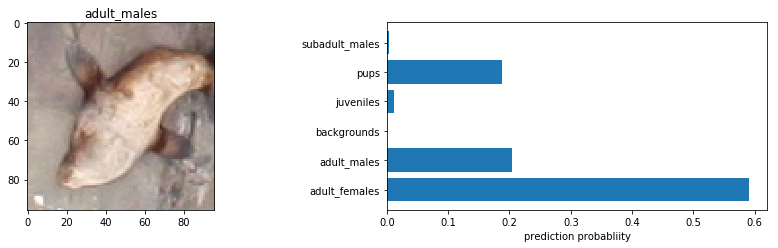

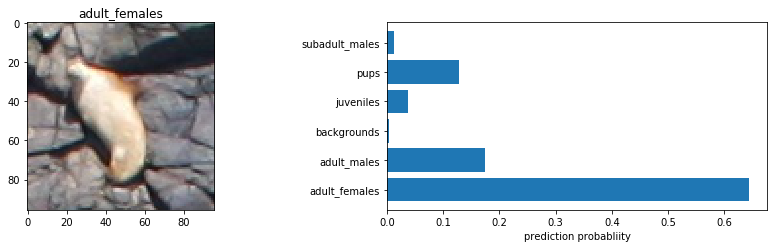

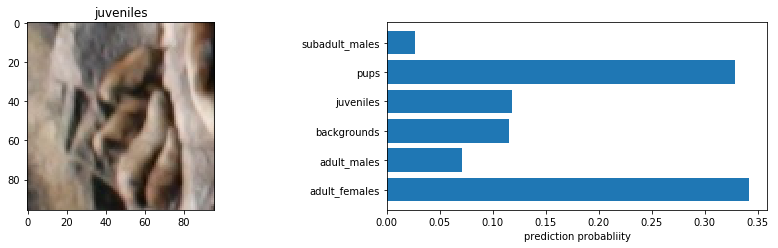

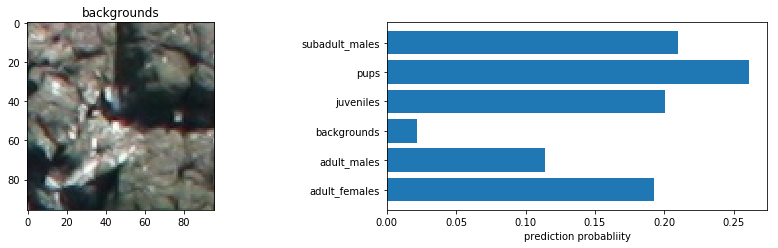

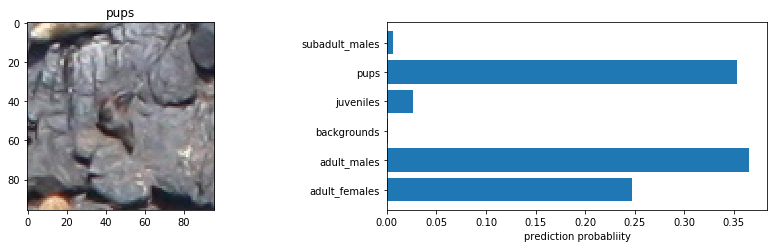

In [212]:
for i in range(5):
    r = np.random.randint(test_generator.n-i)
    img = cv2.imread(PATCH_PATH + 'test/' + test_generator.filenames[r])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    real_class = indice_class_dic[test_generator.classes[r]]
    plt.figure(figsize=(15, 20))
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(img)
    plt.title(real_class)
    plt.subplot(5, 2, 2*i+2)
    singlge_pred = pred[i]
    plt.barh(np.arange(6), singlge_pred)
    plt.yticks(np.arange(6), list(train_generator.class_indices.keys()))
    plt.xlabel('prediction probabliity')

## 3. CNN and FC-CNN

How to convert a CNN into FC-CNN under Keras framework?
 - define the corresponding FC-CNN with respect to CNN
 - do weight mapping

In [213]:
model2= Sequential()
# first layer
model2.add(Convolution2D(8, (5, 5), activation='relu', padding='valid', input_shape=(None, None, 3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))
# second layer
model2.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
# third layer
model2.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
# fourth layer
model2.add(Convolution2D(10, (3, 3), activation='relu', padding='valid'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# No fully connected layers
model2.add(Convolution2D(256, (20, 20), activation='relu'))
model2.add(Convolution2D(6, (1, 1), activation='softmax'))

In [214]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, None, None, 8)     608       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, None, None, 8)     0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, None, None, 5)     365       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, None, None, 5)     230       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, None, None, 10)    460       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, None, None, 10)    0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, None, None, 256)   1024256   
__________

In [215]:
# check that we have the same number of parameters of model2 with respect to model1
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 92, 92, 8)         608       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 46, 46, 8)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 44, 44, 5)         365       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 42, 42, 5)         230       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 40, 40, 10)        460       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 20, 20, 10)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4000)              0         
__________

In [216]:
# weight mapping, firt 6 layers are the same
for i in range(6):
    model2.layers[i].set_weights(model.layers[i].get_weights())

w7, b7 = model.layers[7].get_weights()[0], model.layers[7].get_weights()[1]
w8, b8 = model.layers[8].get_weights()[0], model.layers[8].get_weights()[1]

model2.layers[6].set_weights([w7.reshape(20, 20, 10, 256), b7])
model2.layers[7].set_weights([w8.reshape(1, 1, 256, 6), b8])

In [217]:
# check if the weights are mapping correctly
img = train_generator[0][0]
p = model.predict(img)
print(p.shape, p)
p2 = model2.predict(img)
print(p2.shape, p2)

(1, 6) [[0.39717013 0.13836871 0.00405181 0.05620193 0.39068174 0.01352565]]
(1, 1, 1, 6) [[[[0.39717013 0.13836871 0.00405181 0.05620193 0.39068174 0.01352565]]]]


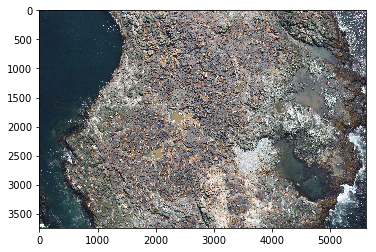

In [218]:
# heatmaps
img = cv2.cvtColor(cv2.imread('../data/images/0.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img)
img_batch = img[np.newaxis,:]

In [219]:
heatmaps = model2.predict(img_batch)

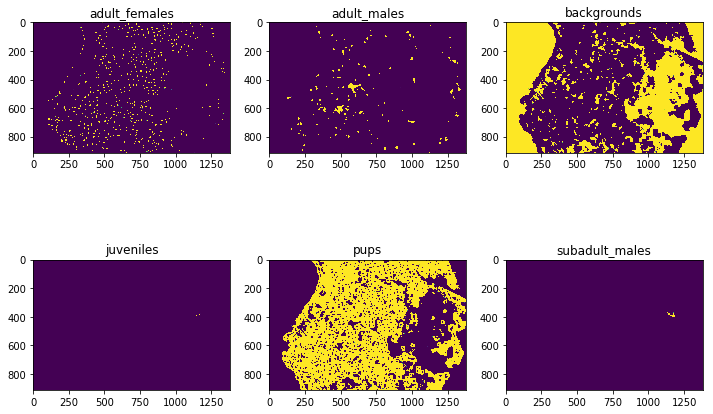

In [220]:
plt.figure(figsize=(12, 8))
for i in range(6):
    heatmap = heatmaps[:, :, :, i][0]
    plt.subplot(2, 3, i+1)
    plt.imshow(heatmap)
    plt.title(indice_class_dic[i])